In [1]:
import numpy as np
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing import image

import matplotlib.pyplot as plt

from ripser import Rips
from persim import PersImage
from persim import PersistenceImager

from itertools import product
import math
from persim import plot_diagrams
from ripser import ripser, lower_star_img
import scipy
from scipy import ndimage

from scipy import sparse

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image

from persim import PersistenceImager
import collections
collections.Iterable = collections.abc.Iterable


from PIL import Image
from numpy import asarray
import os


2024-03-12 15:54:44.785449: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-12 15:54:44.786859: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-12 15:54:44.813620: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-12 15:54:44.814119: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-12 15:54:45.231503: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
N = 200
N_per_class = int(N / 2)
N_in_class = 400

def noise(N, scale):
    return scale * np.random.random((N, 2))

def circle(N, scale, offset):
    return offset + scale * datasets.make_circles(n_samples=N, factor=0.4, noise=0.05)[0]

just_noise = [noise(N_in_class, 150) for _ in range(N_per_class)]

half = int(N_in_class / 2)
with_circle = [np.concatenate((circle(half, 50, 70), noise(half, 150)))
               for _ in range(N_per_class)]

datas = []
datas.extend(just_noise)
datas.extend(with_circle)

# Define labels
labels = np.zeros(N)
labels[N_per_class:] = 1

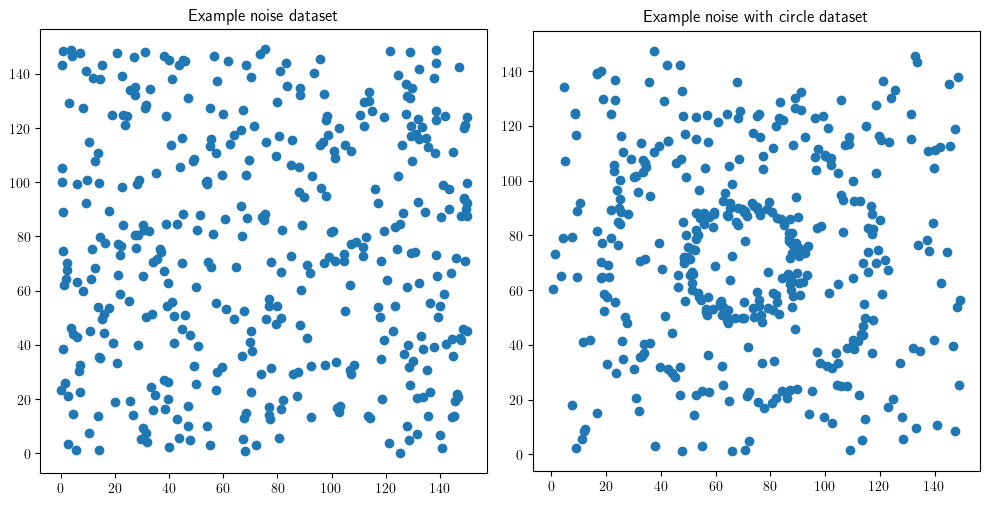

In [3]:
# Visualize the data
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(10,5)

xs, ys = just_noise[0][:,0], just_noise[0][:,1]
axs[0].scatter(xs, ys)
axs[0].set_title("Example noise dataset")
axs[0].set_aspect('equal', 'box')

xs_, ys_ = with_circle[0][:,0], with_circle[0][:,1]
axs[1].scatter(xs_, ys_)
axs[1].set_title("Example noise with circle dataset")
axs[1].set_aspect('equal', 'box')

fig.tight_layout()

In [4]:
rips = Rips(maxdim=1, coeff=2)
diagrams = [rips.fit_transform(data) for data in datas]
diagrams_h1 = [rips.fit_transform(data)[1] for data in datas]

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


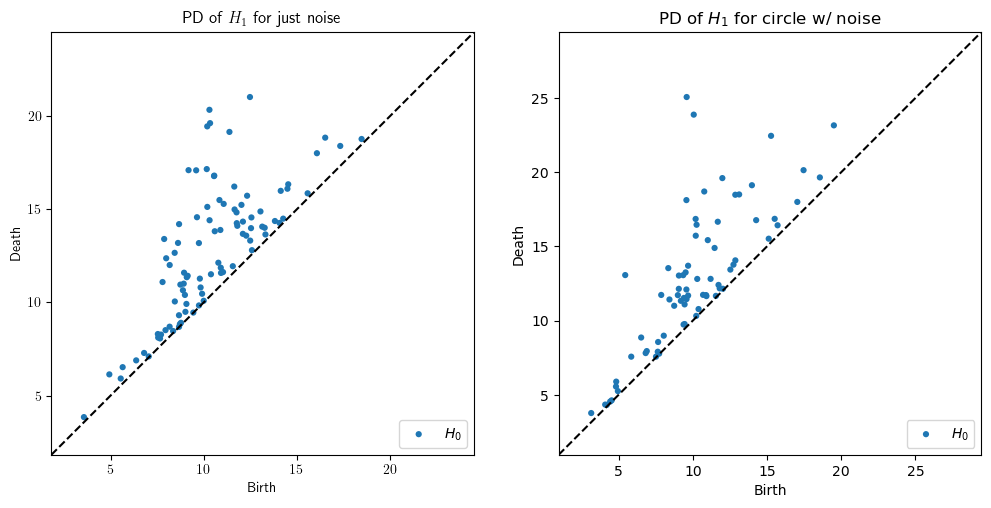

In [5]:
plt.figure(figsize=(12,6))
plt.subplot(121)

rips.plot(diagrams_h1[0], show=False)
plt.title("PD of $H_1$ for just noise")

plt.subplot(122)
rips.plot(diagrams_h1[-1], show=False)
plt.title("PD of $H_1$ for circle w/ noise")

plt.show()

In [6]:
pimgr = PersistenceImager(pixel_size=1)
pimgr.fit(diagrams_h1)
imgs = pimgr.transform(diagrams_h1)

In [7]:
pimgr

PersistenceImager(birth_range=(1.1061326265335083, 32.10613262653351), pers_range=(-0.05988144874572754, 20.940118551254272), pixel_size=1, weight=persistence, weight_params={'n': 1.0}, kernel=gaussian, kernel_params={'sigma': [[1.0, 0.0], [0.0, 1.0]]})

In [8]:
imgs_array = np.array([img.flatten() for img in imgs])

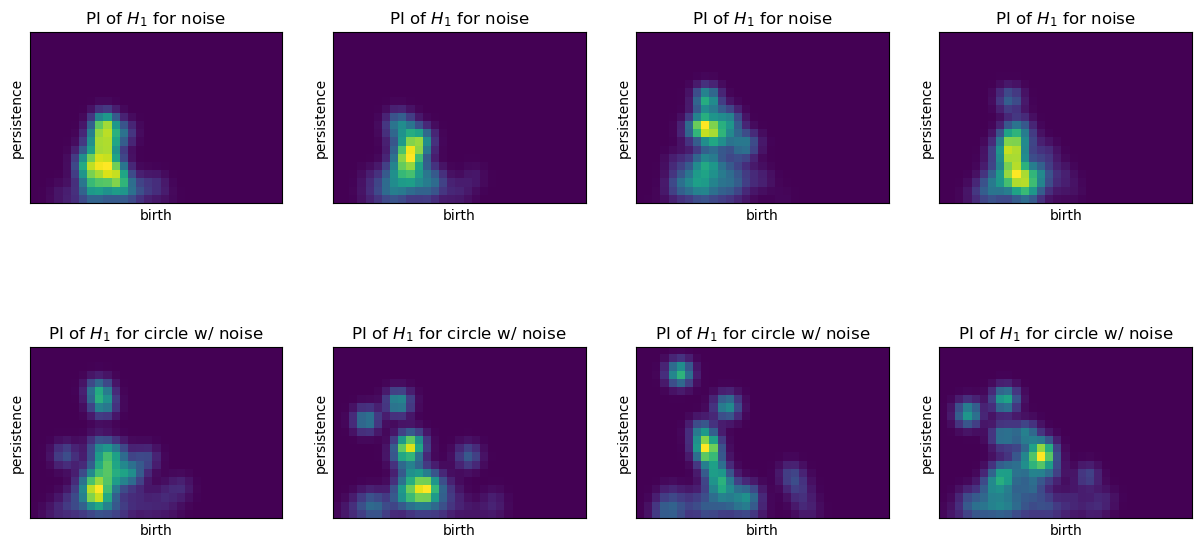

In [9]:
plt.figure(figsize=(15,7.5))

for i in range(4):
    ax = plt.subplot(240+i+1)
    pimgr.plot_image(imgs[i], ax)
    plt.title("PI of $H_1$ for noise")

for i in range(4):
    ax = plt.subplot(240+i+5)
    pimgr.plot_image(imgs[-(i+1)], ax)
    plt.title("PI of $H_1$ for circle w/ noise")

In [10]:
X_train, X_test, y_train, y_test = train_test_split(imgs_array, labels, test_size=0.40, random_state=42)

In [11]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

In [12]:
lr.score(X_test, y_test)

1.0

In [15]:
X_test.shape

(80, 651)

In [2]:
img_path = "/home/olakunle/Downloads/brain_tumors/archive/Training/pituitary_tumor/p (105).jpg"
img = Image.open(img_path)
img_ = asarray(img)

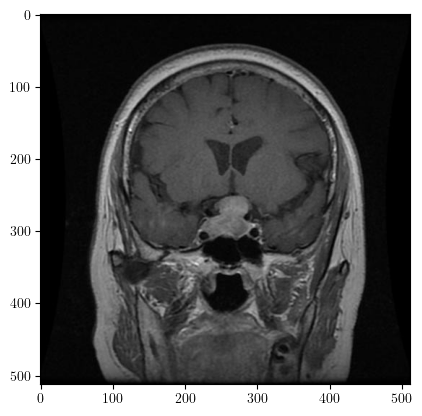

In [4]:
img_gray = 0.299* img_[:,:,0] + 0.587*img_[:,:,1] + 0.114*img_[:,:,2]
plt.imshow(img_gray)
plt.gray()

(-0.5, 511.5, 511.5, -0.5)

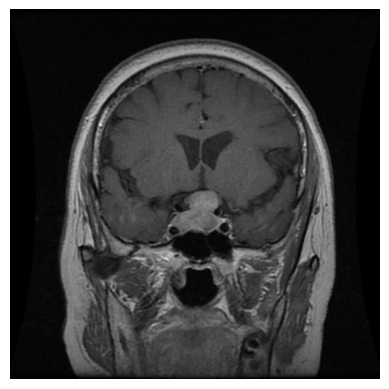

In [6]:
plt.imshow(img_)
plt.axis('off')

In [2]:
import os
path = "/home/olakunle/Downloads/brain_tumors/archive/Training/pituitary_tumor"
dir_list = sorted(os.listdir(path))
len(dir_list)

828

In [3]:
data_s = []
for data_ in dir_list[1:]:
    img = Image.open(path+'/'+data_)
    img_array = asarray(img)
    img_gray_ = 0.299* img_array[:,:,0] + 0.587*img_array[:,:,1] + 0.114*img_array[:,:,2]
    data_s.append(img_gray_)

In [4]:
def lower_star_img(img):
    """
    Construct a lower star filtration on an image
    Parameters
    ----------
    img: ndarray (M, N)
        An array of single channel image data
    Returns
    -------
    I: ndarray (K, 2)
        A 0-dimensional persistence diagram corresponding to the sublevelset filtration
    """
    m, n = img.shape
    idxs = np.arange(m * n).reshape((m, n))
    I = idxs.flatten()
    J = idxs.flatten()
    V = img.flatten()

    # Connect 8 spatial neighbors
    tidxs = np.ones((m + 2, n + 2), dtype=np.int64) * np.nan
    tidxs[1:-1, 1:-1] = idxs
    tD = np.ones_like(tidxs) * np.nan
    tD[1:-1, 1:-1] = img

    for di in [-1, 0, 1]:
        for dj in [-1, 0, 1]:
            if di == 0 and dj == 0:
                continue
            thisJ = np.roll(np.roll(tidxs, di, axis=0), dj, axis=1)
            thisD = np.roll(np.roll(tD, di, axis=0), dj, axis=1)
            thisD = np.maximum(thisD, tD)

            # Deal with boundaries
            boundary = ~np.isnan(thisD)
            thisI = tidxs[boundary]
            thisJ = thisJ[boundary]
            thisD = thisD[boundary]
            I = np.concatenate((I, thisI.flatten()))
            J = np.concatenate((J, thisJ.flatten()))
            V = np.concatenate((V, thisD.flatten()))

    sparseDM = sparse.coo_matrix((V, (I, J)), shape=(idxs.size, idxs.size))
    return ripser(sparseDM, distance_matrix=True, maxdim=1)["dgms"]


In [5]:
def get_dgms(data, hom_dim = 1):
    # Initialize array to store all dgms
    num_images = len(data)
    dgms_arr = []
    
    # Iterate through all images, compute sublevel set filtration
    # for each image and corresponding pers. img for given hom. dim.
    for i in range(num_images):
        dgm = lower_star_img(data[i])[hom_dim]
        dgms_arr.append(dgm)
    return dgms_arr

In [25]:
def merge_dgms(i):
    B = get_dgms(data_s[15*i:15*(i+1)], 1)
    return A.extend(B)
A = merge_dgms(0)

In [ ]:
B = get_dgms(data_s[0:60])


In [31]:
len(C)

30

In [35]:
outfile = open('/home/olakunle/Downloads/pituitary_dgms.pckl', 'wb')
pickle.dump(A, outfile)
outfile.close()

In [ ]:
#outfile = open('.pckl', 'wb')
#pickle.dump(merge_dgms(B), outfile)
#outfile.close()

In [36]:
import pickle

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


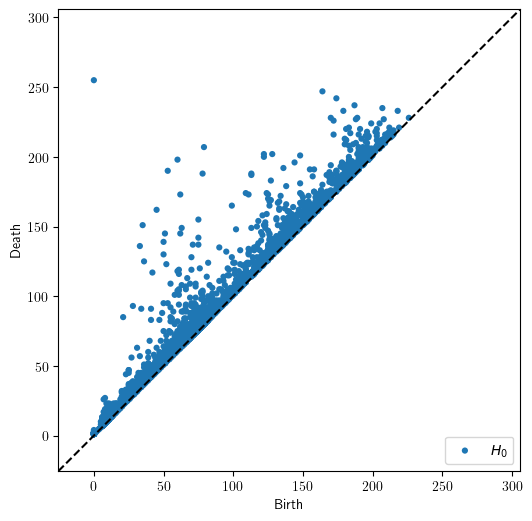

In [13]:
rips = Rips(maxdim=1, coeff=2)

plt.figure(figsize=(12,6))
#plt.subplot(121)

rips.plot(A[1], show=False)
#plt.title("PD of $H_1$ for just noise")

#plt.subplot(122)
#rips.plot(diagrams_h1[-1], show=False)
#plt.title("PD of $H_1$ for circle w/ noise")

plt.show()

In [66]:
pimgr = PersistenceImager(pixel_size=1)
pimgr.fit(A)
imgs = pimgr.transform(A)

In [69]:
imgs[8].shape

(252, 254)

In [14]:
pimgr = PersistenceImager(pixel_size=1)
pimgr.fit(A[13])
imgs = pimgr.transform(A[13])

In [15]:
imgs.shape

(249, 242)

Text(0.5, 1.0, '')

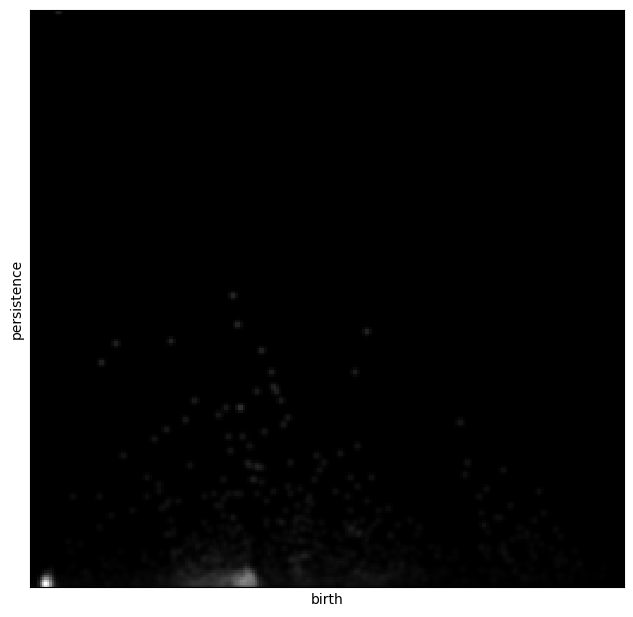

In [24]:
plt.figure(figsize=(15,7.5))
pimgr.plot_image(imgs)
plt.gray()
plt.title("")


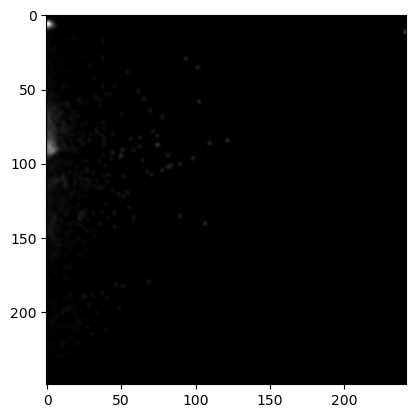

In [90]:
plt.imshow(imgs)
C = np.zeros((imgs.shape[0], imgs.shape[1], 3))
C[:,:,0] = imgs
C[:,:,1] = imgs
C[:,:,2] = imgs


Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


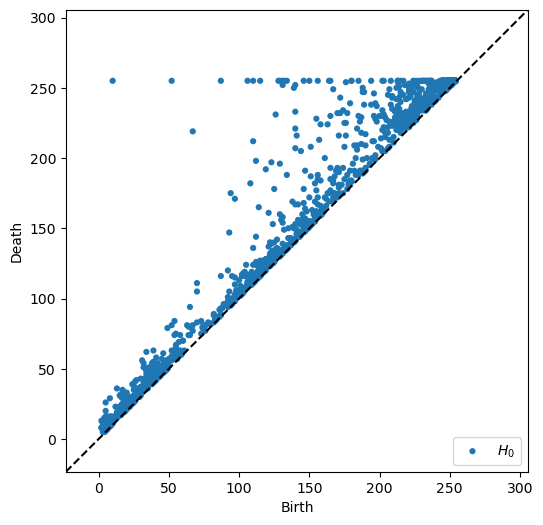

In [34]:
rips = Rips(maxdim=1, coeff=2)

plt.figure(figsize=(12,6))
#plt.subplot(121)

rips.plot(A[7], show=False)
#plt.title("PD of $H_1$ for just noise")

#plt.subplot(122)
#rips.plot(diagrams_h1[-1], show=False)
#plt.title("PD of $H_1$ for circle w/ noise")

plt.show()

In [87]:
gray3d = keras.preprocessing.image.array_to_img(imgs)
gray3d.save("/home/olakunle/Downloads/pi_1.jpg")

ValueError: Expected image array to have rank 3 (single image). Got array with shape: (249, 242)

In [88]:
imgs.shape

(249, 242)

In [3]:
import numpy as np
np.log(np.exp(1))

0.9999999999999999

In [4]:
import numpy as np
def capacity(p):
    a = 1/np.log(2)*(-p*np.log(p) -(1-p)*np.log(1-p))
    return 1-a

In [2]:
def bsearch(rate,prec, epsilon):
    a = 0
    b = 1/2
    value = rate+prec
    for i in range(100):
        midval = (a+b)/2
        if capacity(midval) - value > epsilon:
            a = midval
        elif value - capacity(midval) > epsilon:
            b = midval
        
        else:
            return midval

In [5]:
result = bsearch(0.5, 1e-6, 1e-8 )
result

0.11002753302454948

In [52]:
result*32

3.5208810567855835

In [7]:
capacity(0.008)

0.9327784552416931

In [11]:
import numpy as np
A = np.array([ [[1,0,3]], [[0,6,7]], [[9,5,6]] ])
b = np.array([ [[0]], [[1]], [[2]]])


In [57]:
from sklearn.utils import shuffle
A, b = shuffle(A, b, random_state=36)


In [58]:
A

array([[[9, 5, 6]],

       [[0, 6, 7]],

       [[1, 0, 3]]])

In [59]:
b

array([[[2]],

       [[1]],

       [[0]]])

In [8]:
import numpy as np
import random

In [2]:
from itertools import permutations

In [4]:
A = list(permutations(range(1,4)))
A


[(1, 2, 3), (1, 3, 2), (2, 1, 3), (2, 3, 1), (3, 1, 2), (3, 2, 1)]

In [28]:
B = [ [1,0,1, 1], [0,1,0,1], [1,1,1,1] ]
random.shuffle(B)
B

[[0, 1, 0, 1], [1, 1, 1, 1], [1, 0, 1, 1]]